# Optimizer and Coloring

In [7]:
import time
import random
import numpy as np
import pulp as plp
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

from gurobipy import *
import multiprocessing

def Model(weights, signed_matrix):

    objectivevalue=[]
    objs=[]
    solveTime=[]
    
    index=0 
    order=len(signed_matrix[index])

    ###############################################################################################
    opt_model = plp.LpProblem(name="Binary_Model",sense = plp.LpMinimize)

    x=[]
    for i in range(0,order):
        x.append(plp.LpVariable(lowBound=0,upBound=1, cat=plp.LpBinary, name='x'+str(i)))
    z={}    
    for (i,j) in (weights[index]):
        z[(i,j)]=plp.LpVariable(lowBound=0,upBound=1, cat=plp.LpBinary, name='z'+str(i)+','+str(j))
    ###############################################################################################
    OFV = 0
    for (i,j) in (weights[index]):
        OFV += z[(i,j)]

    opt_model.setObjective(OFV)

    for (i,j) in (weights[index]):
        opt_model.addConstraint( z[(i,j)] >= x[i] - ((weights[index])[(i,j)])*x[j] -\
                        (1-(weights[index])[(i,j)])/2)
        opt_model.addConstraint( z[(i,j)] >= -x[i] + ((weights[index])[(i,j)])*x[j] +\
                        (1-(weights[index])[(i,j)])/2)   

    ###############################################################################################
    
    start_time = time.time()
    status = opt_model.solve(solver = plp.getSolver('GUROBI_CMD'))#'COIN_CMD'))
    solveTime.append(time.time() - start_time) 

    ###############################################################################################

    varsdict = {}
    for v in opt_model.variables():
        varsdict[v.name] = v.varValue    
                    
    return float(opt_model.objective.value()), varsdict

def Prepare_Data(matrices):

    signed_matrices=[]
    unsigned_matrices=[]
    weights = []
    graphs=[]
    for signed_matrix in matrices:

        Graph=nx.from_numpy_matrix(signed_matrix)

        mapping=dict(zip(Graph.nodes(),range(len(Graph.nodes()))))
        Graph=nx.relabel_nodes(Graph,mapping) 

        graphs.append(Graph)

        signed_matrix = nx.to_numpy_matrix(Graph)
        unsigned_matrix = abs(signed_matrix)    

        weighted_edges=nx.get_edge_attributes(Graph, 'weight') 
        w={}
        for (u,v) in weighted_edges:
            if u<v:
                w[(u,v)] = weighted_edges[(u,v)]
            if u>v:
                w[(v,u)] = weighted_edges[(u,v)]

        signed_matrices.append(signed_matrix)
        unsigned_matrices.append(unsigned_matrix)
        weights.append(w)

    return graphs, weights, signed_matrices

def color_nodes(G,variables):
    
    d = {}
    for key, value in variables.items():
        if "x" in key:
            #print(key[1:],value)
            d[int(key[1:])]=value

    var = dict(sorted(d.items()))
    
    node_colors=[]
    for key,value in var.items():
        if value==1:
            node_colors.append("Black")
        else:
            node_colors.append("Silver")
            
    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        #print(node,color)
        attr[node]=color
        
    nx.set_node_attributes(G, attr, 'color')
    
    return G

def Add_Weights(H,k):
    
    N = len(H.edges())

    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(n+m)
    a[:m] = -1
    np.random.shuffle(a)
    
    dic={}
    for e,value in zip(H.edges(),a):
        dic[e] = value
    
    nx.set_edge_attributes(H, dic,'weight')
    
    return H

# Creating Graphs

In [8]:
def create_data(n,num):
    
    k = 0.5
    
    if num==1:
        G = nx.grid_2d_graph(n,n)
    if num==2:
        G = nx.triangular_lattice_graph(n,n)
    if num==3:
        G= nx.path_graph(n)

    N = len(G.nodes())
    
    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(N)
    a[:m] = -1
    np.random.shuffle(a)
    
    node_colors=[]
    for i in a:
        if i==1:
            node_colors.append("Silver")
        else:
            node_colors.append("Black")

    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        attr[node]=color

    nx.set_node_attributes(G, attr, 'color')
    
    G = Add_Weights(G,1.0)
    
    
    matrix = nx.to_numpy_matrix(G)
    g, weights, signed_matrix = Prepare_Data([matrix])

    fi,vr = Model(weights, signed_matrix)
    #frustrations.append(fi)
    G = color_nodes(G,vr)
    
    pos = nx.spring_layout(G, weight=None)
    nx.set_node_attributes(G,pos,'pos')
    

    return G

def Creation(n,choice):
    k = 0.5
    
    if choice==1:
        G = nx.grid_2d_graph(n,n)
    if choice==2:
        G = nx.triangular_lattice_graph(n,n)
    if choice==3:
        G= nx.path_graph(n)

    N = len(G.nodes())
    
    m = random.randrange(0,N)
    n = N-m

    a = np.ones(N)
    a[:m] = -1
    np.random.shuffle(a)
    
    node_colors=[]
    for i in a:
        if i==1:
            node_colors.append("Silver")
        else:
            node_colors.append("Black")

    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        attr[node]=color

    nx.set_node_attributes(G, attr, 'color')
    
    G = Add_Weights(G,1.0)
    
    pos = nx.spring_layout(G, weight=None)
    nx.set_node_attributes(G,pos,'pos')
    
    return G

## Plot

In [35]:
def Plot2D(G,size=5):

    H0 = G.copy()
    pos =nx.get_node_attributes(H0,'pos')
    node_colors=nx.get_node_attributes(H0,'color')

    edge_colors = []
    for n1,n2,val in H0.edges.data():

        #print(n1,n2)
        if H0.nodes[n1]['color']==H0.nodes[n2]['color']:

            if H0.nodes[n1]['color'] ==H0.nodes[n2]['color'] == "Black":
                edge_colors.append("red")
                #negative +=1
            if H0.nodes[n1]['color'] ==H0.nodes[n2]['color'] == "Silver":
                edge_colors.append("green")
                #positive +=1
        else:
                edge_colors.append("lightgrey")

    attr2 = {}
    for edge,color in zip(H0.edges(),edge_colors):

        #print(edge,color)
        attr2[edge]=color

    nx.set_edge_attributes(H0, attr2, 'edge_color')
    
    edge_colors=nx.get_edge_attributes(H0,'edge_color')

    fig, ax = plt.subplots(figsize=(size,size))
    nx.draw(H0,pos,node_size=50,edge_color=edge_colors.values(),node_color=node_colors.values(),with_labels=False)

# Frustration Calculations 

In [13]:
def frustration_count(G):
    s = 0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color']:
            s+=1
    return s

def color_of_frustration(H):
    
    positive=0
    negative=0

    for n1,n2,val in H.edges.data():
        
        G = H.copy() 
        color1 = G.nodes[n1]['color']
        color2 = G.nodes[n2]['color']
        #print(n1,n2,color1,color2)
        #print(color1 == color2 or color2==color1)
        if color1 == color2 or color2==color1:
            #print("true")
            if color1 == color2 == "Black":
                #print("\tadd negative")
                negative +=1
            if color1 == color2 == "Silver":
                #print("\tadd positive")
                positive +=1
                
    return positive,negative

def calculate_delta(G):
    
    p,n = color_of_frustration(G)
    #print("p=",p,"n=",n)
    
    if p>n:
        return int(np.sqrt((p-n)**2))
    else:
        return int(np.sqrt((n-p)**2))

## Randomized Graph

L = 165 f = 93 d = 33
p = 63 n = 30


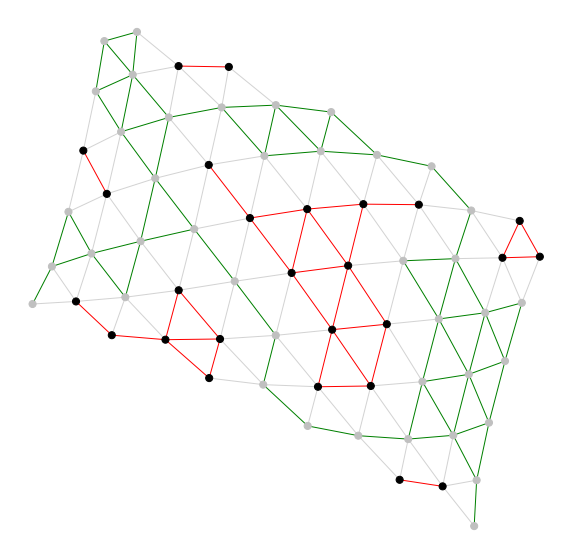

In [29]:
G = Creation(10,2)

Plot2D(G,10)

L = len(G.edges())

print("L =",L,"f =",frustration_count(G),"d =",calculate_delta(G))

p,n = color_of_frustration(G)

print("p =",p,"n =",n)

##  Minimum Frustration

L = 165 f = 50 d = 10
p = 30 n = 20


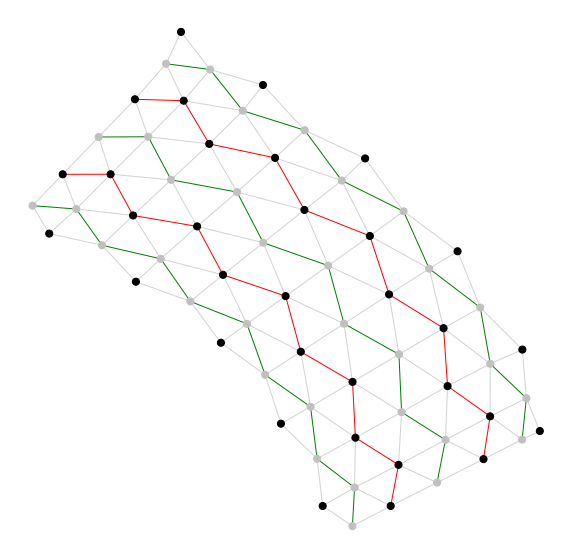

In [34]:
G = create_data(10,2)

Plot2D(G,10)

L = len(G.edges())

print("L =",L,"f =",frustration_count(G),"d =",calculate_delta(G))

p,n = color_of_frustration(G)

print("p =",p,"n =",n)

# Simulated Annealing for targeting Delta

In [40]:
import random
import math
from random import choice
from random import sample
import numpy.random as rn

from sklearn.metrics import mean_squared_error

def random_neighbour(G):
 
    H = G.copy()
    
    random_node = sample(H.nodes(),1)[0]
    
    chosen_color = H.nodes[random_node]['color']
    if chosen_color == "Silver":
        H.nodes[random_node]['color'] = "Black"
    else:
        H.nodes[random_node]['color'] = "Silver"
    
    return H

def target_delta(state, target):
    
    new = calculate_delta(state)
    
    mse = np.abs(target-new)

    return mse

def acceptance_probability(cost, new_cost, temperature):
    if new_cost < cost:
        return 1
    else:
        p = np.exp(- (new_cost - cost) / temperature)
        return p

def temperature(fraction):
    
    value = max(0.01, min(1, 1 - fraction))
    return value

def Annealing(G0,target, maxsteps=1000):

    
    state = G0.copy()
    cost_funct = target_delta
    
    cost = cost_funct(state,target)
    
    if cost == 0:
        return state
    
    for step in range(maxsteps):
        
        fraction = step / float(maxsteps)
        T = temperature(fraction)
        
        new_state = random_neighbour(state)
        
        new_cost = cost_funct(new_state,target)
        
        if acceptance_probability(cost, new_cost, T) > rn.random():
            
            state, cost = new_state, new_cost
            if cost == 0:
                return state    
    return state

# Quenching Function

In [41]:
def Quench_Process(Gs):

    total=[]
    Delta = []
    for i in tqdm(range(len(Gs))):
        
        H = Gs[i].copy()
        
        res=[]
        res.append(frustration_count(H))
        deltas = []
        deltas.append(calculate_delta(H))
        
        G = H.copy()
        for k in range(1,500):
            
            nx.algorithms.connected_double_edge_swap(G, nswap=1)
            
            fr = frustration_count(G)
            res.append(fr)
            deltas.append(calculate_delta(G))

        total.append(res) 
        Delta.append(deltas)
        
    return np.array(total),np.array(Delta)

def Get_Probabilites(data,Edge,repeat):

    p_t=[]
    for t in range(len(data[0])):

        prob=[]
        for i in range(0,Edge):
            prob.append(np.count_nonzero(np.array(data[:,t]) == i))
        p_t.append(np.array(prob)/repeat)

    P_t = np.array(p_t)

    p_even=[]
    for l in P_t:
        p_even.append(l[::2])

    P_even = np.array(p_even)

    return P_t,P_even

def Get_Means(data):
    
    total = np.array(data)
    final = []
    for i in range(0,len(total[0])):
        final.append((np.mean(total[:,i]),np.std(total[:,i])))

    return np.array(final)

# Testing

In [66]:
def Quench(G0):
    

    total=[]
    
    #d0 = calculate_delta(G0)
    for i in tqdm(range(1000)):
        
        H = G0.copy()
        
        res=[]
        res.append(frustration_count(H))
        
        G = H.copy()
        for k in (range(1,1000)):
            
            nx.algorithms.connected_double_edge_swap(G, nswap=1)

            res.append(frustration_count(G))
            
            """
            d = calculate_delta(G)
            if d != d0:
                print("Delta changed!")
                return 0
            """
            
        total.append(res) 
        
    return np.array(total)

Target =  20
L = 40 f = 28 d = 20

t =  0.00606226921081543 

L = 40 f = 28 d = 20


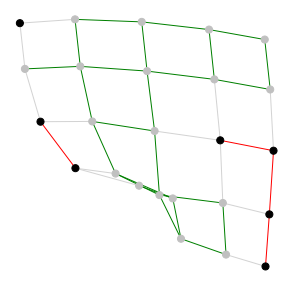

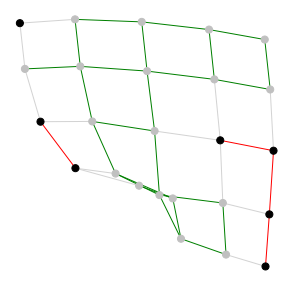

In [68]:
import time

G0 = Creation(5,1)
L = len(G0.edges())
target = int(L/2) 

d0 = calculate_delta(G0)
print("Target = ",target)
print("L =",L,"f =",frustration_count(G0),"d =",d0)

Plot2D(G0,5)

##########################################
start_time = time.time()
G = Annealing( G0, target, maxsteps=500)
print("\nt = ",time.time() - start_time,"\n") 
##########################################

print("L =",L,"f =",frustration_count(G),"d =",calculate_delta(G))

Plot2D(G,5)

In [69]:
data = Quench(G)

P_t,P_even = Get_Probabilites(data,L,1000)

Means  = Get_Means(data)

100%|██████████| 1000/1000 [02:52<00:00,  5.81it/s]


In [70]:
edge = L

from sympy import *
f0 = 28

t = symbols('t')
x = symbols('x', cls=Function)
L = symbols('L', real=True)
d = symbols('d', real=True)

gsol = dsolve(x(t).diff(t) - ((1 - 2*L)*x(t) + L*(L - 1) + d**2)/(L*(L - 1)), x(t),ics={x(0): f0})

l=edge
k=20
sol = gsol.subs({L: l,d:k})
lmbd_sol = lambdify(t, sol.rhs)

In [71]:
data1 = P_t
data2 = P_even
data3 = Means

In [73]:
import random
import matplotlib
import tkinter as Tk
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.widgets import TextBox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

matplotlib.use('TkAgg')

root = Tk.Tk()
root.wm_title("Embedding in TK")
fig = plt.Figure(figsize=(10,5))
canvas = FigureCanvasTkAgg(fig, root)
canvas.get_tk_widget().pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)


###############################################

ax=fig.add_subplot(121)
fig.subplots_adjust(bottom=0.25)

fig.suptitle('L='+str(l)+', d='+str(k), fontsize=16)

t=0
l11, = ax.plot([i for i in range(len(data1[t]))], data1[t])
l12, = ax.plot([i*2 for i in range(len(data2[t]))], data2[t], lw=2)
line = ax.axvline(x=data3[t,0],linestyle="--",color="green")
ax.set_ylim(0,1)

ax.set_xlabel("f")
ax.set_ylabel("P(f)")
ax.grid()

###############################################
ax_time = fig.add_axes([0.12, 0.1, 0.78, 0.03])
s_time = Slider(ax_time, 'Time', 0, 999, valinit=0)

tekstić = ax.text(0.05, 0.95, s_time.val, transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
###############################################

ax2=fig.add_subplot(122)

ax2.errorbar([i for i in range(len(data3[:,0]))],data3[:,0],data3[:,1],alpha=0.1,color="blue")
ax2.plot([i for i in range(len(data3[:,0]))],data3[:,0],color="blue")
line2 = ax2.axvline(x=t,linestyle="-",color="red")
line3 = ax2.axhline(y=data3[t,0],linestyle="-",color="red")

xs = np.linspace(0,999,999)
ax2.plot(xs,lmbd_sol(xs),linestyle="--",color="green")


ax2.set_xlabel("t")
ax2.set_ylabel("f(t)")
ax2.set_ylim(0,edge)
ax2.grid()


###############################################

def update(val):

    value = int(s_time.val)

    l11.set_ydata(data1[value])
    l12.set_ydata(data2[value])
    line.set_xdata(data3[value,0])
    
    tekstić.set_text("t="+str(value)+", E[f]="+str(data3[value,0]))#+"-> "+str(np.round(lmbd_sol(value),2)))

    line2.set_xdata(value)
    line3.set_ydata(data3[value,0])
    
    fig.canvas.draw_idle()

from tkinter import Button
Button(root, text="Quit", command=root.destroy).pack()
    
    
s_time.on_changed(update)

Tk.mainloop()

In [84]:
from sklearn.metrics import mean_squared_error


xs = np.linspace(0,1000,1000)
y_predicted= lmbd_sol(xs)
y_actual= data3[:,0]

err = mean_squared_error(y_actual, y_predicted)

print(err)

0.19453554288107636


# importing previously calculated values 

In [110]:
def analytical(L,f0,d0):

    edge = L

    f0 = f0

    t = symbols('t')
    x = symbols('x', cls=Function)
    L = symbols('L', real=True)
    d = symbols('d', real=True)

    gsol = dsolve(x(t).diff(t) - ((1 - 2*L)*x(t) + L*(L - 1) + d**2)/(L*(L - 1)), x(t),ics={x(0): f0})

    l=edge
    k=d0
    sol = gsol.subs({L: l,d:k})
    lmbd_sol = lambdify(t, sol.rhs)
    
    return lmbd_sol


In [124]:
from sympy import *


import random
import matplotlib
import tkinter as Tk
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.widgets import TextBox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

def Tkinter_Plot(data1,data2,data3,L,f0,d0):
    
    lmbd_sol = analytical(L,f0,d0)


    matplotlib.use('TkAgg')

    root = Tk.Tk()
    root.wm_title("Embedding in TK")
    fig = plt.Figure(figsize=(10,5))
    canvas = FigureCanvasTkAgg(fig, root)
    canvas.get_tk_widget().pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)


    ###############################################

    ax=fig.add_subplot(121)
    fig.subplots_adjust(bottom=0.25)

    fig.suptitle('L='+str(L)+', d='+str(d0), fontsize=16)

    t=0
    l11, = ax.plot([i for i in range(len(data1[t]))], data1[t])
    l12, = ax.plot([i*2 for i in range(len(data2[t]))], data2[t], lw=2)
    line = ax.axvline(x=data3[t,0],linestyle="--",color="green")
    ax.set_ylim(0,1)

    ax.set_xlabel("f")
    ax.set_ylabel("P(f)")
    ax.grid()

    ###############################################
    ax_time = fig.add_axes([0.12, 0.1, 0.78, 0.03])
    s_time = Slider(ax_time, 'Time', 0, len(data1)-1, valinit=0)

    tekstić = ax.text(0.05, 0.95, s_time.val, transform=ax.transAxes, fontsize=14,
            verticalalignment='top')
    ###############################################

    ax2=fig.add_subplot(122)

    ax2.errorbar([i for i in range(len(data3[:,0]))],data3[:,0],data3[:,1],alpha=0.1,color="blue")
    ax2.plot([i for i in range(len(data3[:,0]))],data3[:,0],color="blue")
    line2 = ax2.axvline(x=t,linestyle="-",color="red")
    line3 = ax2.axhline(y=data3[t,0],linestyle="-",color="red")

    xs = np.linspace(0,len(data1),len(data1))
    ax2.plot(xs,lmbd_sol(xs),linestyle="--",color="green")


    ax2.set_xlabel("t")
    ax2.set_ylabel("f(t)")
    ax2.set_ylim(0,L)
    ax2.grid()


    ###############################################

    def update(val):

        value = int(s_time.val)

        l11.set_ydata(data1[value])
        l12.set_ydata(data2[value])
        line.set_xdata(data3[value,0])

        tekstić.set_text("t="+str(value)+", E[f]="+str(data3[value,0]))#+"-> "+str(np.round(lmbd_sol(value),2)))

        line2.set_xdata(value)
        line3.set_ydata(data3[value,0])

        fig.canvas.draw_idle()

    from tkinter import Button
    Button(root, text="Quit", command=root.destroy).pack()


    s_time.on_changed(update)

    Tk.mainloop()

### L = 180, f = 0, d = 0

In [128]:
from sklearn.metrics import mean_squared_error

errors = []

In [129]:
L = 180
f0 = 0
d0 = 0

data1 = np.load("L180F0D0_1.npy")
data2 = np.load("L180F0D0_2.npy")
data3 = np.load("L180F0D0_3.npy")

Tkinter_Plot(data1,data2,data3,L,f0,d0)

lmbd_sol = analytical(L,f0,d0)
    
xs = np.linspace(0,1000,1000)
y_predicted= lmbd_sol(xs)
y_actual= data3[:,0]

err = mean_squared_error(y_actual, y_predicted)
errors.append(err)

### L = 165, f = 50, d = 10

In [130]:
L = 165
f0 = 50
d0 = 10

data1 = np.load("L165F50D10_1.npy")
data2 = np.load("L165F50D10_2.npy")
data3 = np.load("L165F50D10_3.npy")

Tkinter_Plot(data1,data2,data3,L,f0,d0)

lmbd_sol = analytical(L,f0,d0)
    
xs = np.linspace(0,1000,1000)
y_predicted= lmbd_sol(xs)
y_actual= data3[:,0]

err = mean_squared_error(y_actual, y_predicted)
errors.append(err)

### L = 630, f = 200, d = 0

In [131]:
L = 630
f0 = 200
d0 = 0

data1 = np.load("L630F200D0_1.npy")
data2 = np.load("L630F200D0_2.npy")
data3 = np.load("L630F200D0_3.npy")

Tkinter_Plot(data1,data2,data3,L,f0,d0)

lmbd_sol = analytical(L,f0,d0)
    
xs = np.linspace(0,1000,1000)
y_predicted= lmbd_sol(xs)
y_actual= data3[:,0]

err = mean_squared_error(y_actual, y_predicted)
errors.append(err)

### L = 630, f = 322, d = 50

In [132]:
L = 630
f0 = 322
d0 = 50


data1 = np.load("L630F322D50_1.npy")
data2 = np.load("L630F322D50_2.npy")
data3 = np.load("L630F322D50_3.npy")

Tkinter_Plot(data1,data2,data3,L,f0,d0)

lmbd_sol = analytical(L,f0,d0)
    
xs = np.linspace(0,1000,1000)
y_predicted= lmbd_sol(xs)
y_actual= data3[:,0]

err = mean_squared_error(y_actual, y_predicted)
errors.append(err)

In [133]:
errors

[0.6420647210263773,
 1.1250210479454075,
 2.1575429903432313,
 1.3579906506218897]

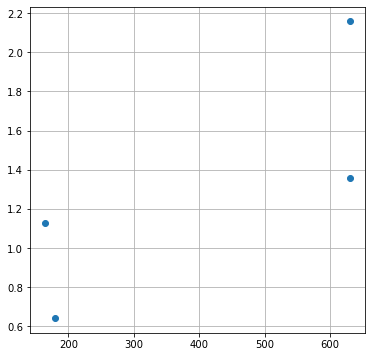

In [137]:
%matplotlib inline

fig, ax = plt.subplots(figsize=[6,6])

ax.scatter([180,165,630,630],errors)
ax.grid()
plt.show()

In [140]:
import plotly.graph_objects as go
import numpy as np

# Helix equation
t = np.linspace(0, 10, 50)
x, y, z = np.cos(t), np.sin(t), t

Ls = [180,165,630,630]
ds = [0,10,0,50]


fig = go.Figure(data=[go.Scatter3d(x=Ls, y=ds, z=errors,
                                   mode='markers')])

fig.show()